In [1]:
import numpy as np
import scipy as sp
import jax.numpy as jnp
import jax.scipy as jsp
import jax.lax as jlx
import jax
from matplotlib import pyplot as plt
from jax.scipy.optimize import minimize

In [3]:
# initial parameters of the equation
num_space_grid, num_time_grid, num_space_IC, num_time_BC = 10, 10, 100, 50
viscosity = 0.01 / np.pi

In [4]:
# dense domain, where points for RAR will be picked
x = np.linspace(-1, 1, 100)
t = np.linspace(0, 1, 100)
D = np.array([[i, y] for i in x for y in t])
D.shape

(10000, 2)

In [5]:
# grid built on the domain, those are the points where the PINN will try to minimize the residual
time_sample = np.linspace(0, 1, num_time_grid)
space_sample = np.linspace(-1, 1, num_space_grid)
print(time_sample.shape, space_sample.shape)
grid = np.array([[x, y] for x in space_sample for y in time_sample])
grid.shape

(10,) (10,)


(100, 2)

In [6]:
# points for the constraining on initial conditions
IC_x = np.array([[i, 0] for i in np.linspace(-1, 1, num_space_IC)])
IC_val = np.array([-np.sin(np.pi * i) for i in np.linspace(-1, 1, num_space_IC)])
IC_x.shape, IC_val.shape

((100, 2), (100,))

In [7]:
# points for the constraining on boundary conditions
temp_1 = np.array([[-1, i] for i in np.linspace(0, 1, num_time_BC)])
temp_2 = np.array([[1, i] for i in np.linspace(0, 1, num_time_BC)])
BC_x = np.concatenate([temp_1, temp_2])
BC_val = np.zeros(len(BC_x))
BC_x.shape, BC_val.shape

((100, 2), (100,))

In [8]:
layers = [2, 16, 8, 4, 1]

In [9]:
# initializing weights and biases for the whole neural networks
def initialize(layers_size):
  np.random.seed(0) # for reproducibility
  params = list()
  for i in range(len(layers_size) - 1):
    n, m = layers_size[i + 1], layers_size[i]
    params.append(np.random.normal(0, np.sqrt(2 / (n + m)), (n, m))) # matrix --> Normal(0, sqrt(2/n+m))
    params.append(np.zeros((n, ))) # vectors --> 0
  return params

params = initialize(layers) # simple FFNN --> more layers with less nodes --> typical in PINN
len(params)

8

In [10]:
# functions for computing the forward pass of the network --> 2 variations
def ANN_layer(data, params):
    W, b = params
    return jlx.map(lambda x: jnp.dot(W, x) + b, data)

ANN_layer_fast = jax.jit(ANN_layer)

def ANN(x, params):
  res = x
  for i in range(0, len(params) - 2, 2):
      res = jnp.tanh(ANN_layer_fast(res, params[i:i + 2]))
  res = ANN_layer_fast(res, params[-2:])
  return res[:, 0]

ANN_fast = jax.jit(ANN)

def ANN_single_point(point, params): # same function, but for a single datapoint to forcast
    res = point
    for i in range(0, len(params) - 2, 2):
        res = jnp.tanh(jnp.dot(params[i], res) + params[i + 1])
    res = jnp.dot(params[-2], res) + params[-1]
    return res[0]

ANN_single_point_fast = jax.jit(ANN_single_point)

ANN_single_point_fast(grid[0], params)

Array(0.09077528, dtype=float32)

In [11]:
# helper function, used to compute the derivative of the network with respect of the inputs
def ANN_separate(x, t, params):
    grid_sep = jnp.hstack([x.reshape((-1, 1)), t.reshape((-1, 1))])
    return ANN_fast(grid_sep, params)

grad_x = jax.jit(jax.jacrev(ANN_separate, argnums=0))

# all the specific functions for the derivative needed
def y_der_x_(x, t, params):
    return jnp.diagonal(grad_x(x, t, params))
y_der_x_fast_ = jax.jit(y_der_x_)

grad_t = jax.jit(jax.jacrev(ANN_separate, argnums=1))

def y_der_t_(x, t, params):
    return jnp.diagonal(grad_t(x, t, params))
y_der_t_fast_ = jax.jit(y_der_t_)

grad_x_x = jax.jit(jax.jacrev(y_der_x_, argnums=0))
def y_der_x_der_x_(x, t, params):
    return jnp.diagonal(grad_x_x(x, t, params))
y_der_x_der_x_fast_ = jax.jit(y_der_x_der_x_)

print(y_der_x_fast_(grid[:, 0], grid[:, 1], params)[0])
print(y_der_t_fast_(grid[:, 0], grid[:, 1], params)[0])
print(y_der_x_der_x_fast_(grid[:, 0], grid[:, 1], params)[0])

-0.012708768
0.060691588
-0.115106225


In [12]:
# implementation of the loss function, unifying of all the subcomponents of the loss
lam_1, lam_2, lam_3 = 1, 1, 1

def loss_points(params):
    pred_IC = ANN_fast(IC_x, params)
    pred_BC = ANN_fast(BC_x, params)
    return lam_1 * jnp.mean(jnp.square(IC_val - pred_IC)) + lam_2 * jnp.mean(jnp.square(BC_val - pred_BC))

loss_points_fast = jax.jit(loss_points)

def loss_grid(params):
    y_val = ANN_fast(grid, params)
    y_der_x_val = y_der_x_fast_(grid[:, 0], grid[:, 1], params)
    y_der_t_val = y_der_t_fast_(grid[:, 0], grid[:, 1], params)
    y_der_x_der_x_val = y_der_x_der_x_fast_(grid[:, 0], grid[:, 1], params)

    return lam_3 * jnp.mean(jnp.square(y_der_t_val + y_val * y_der_x_val - viscosity * y_der_x_der_x_val))

loss_grid_fast = jax.jit(loss_grid)

def loss_RAR(S, params): # used in the training cycle for computing the current error for RAR method
    y_val = ANN_fast(S, params)
    y_der_x_val = y_der_x_fast_(S[:, 0], S[:, 1], params)
    y_der_t_val = y_der_t_fast_(S[:, 0], S[:, 1], params)
    y_der_x_der_x_val = y_der_x_der_x_fast_(S[:, 0], S[:, 1], params)

    res = y_der_t_val + y_val * y_der_x_val - viscosity * y_der_x_der_x_val # residual of the equation

    return res, jnp.mean(jnp.square(res)) # estimate of the PDE residuals by Monte Carlo integration

loss_RAR_fast = jax.jit(loss_RAR)

def loss(params):
    return loss_points_fast(params) + loss_grid_fast(params)

loss_fast = jax.jit(loss)
loss_grad = jax.jit(jax.grad(loss, argnums=0))
loss_fast(params)

Array(0.4397442, dtype=float32)

In [13]:
loss_grad(params)

[Array([[-0.02289331, -0.01358984],
        [ 0.01355634,  0.00340348],
        [ 0.10121615,  0.03557109],
        [-0.06881518, -0.0334495 ],
        [-0.04849807, -0.02277191],
        [-0.00719104, -0.00197864],
        [-0.00507342,  0.0020069 ],
        [-0.09083584, -0.04735284],
        [ 0.11025014,  0.04918238],
        [ 0.09505164,  0.03948465],
        [ 0.10752297,  0.03830485],
        [-0.07779812, -0.02978757],
        [-0.08922563, -0.02698124],
        [ 0.07075912,  0.03177646],
        [ 0.09449328,  0.04416561],
        [-0.01709148, -0.01002818]], dtype=float32),
 Array([-0.00441147, -0.00198598, -0.00381975, -0.00552631, -0.00300904,
         0.00119457,  0.0041229 , -0.00988972,  0.00527903,  0.00029683,
        -0.0028107 ,  0.00176595,  0.00736893,  0.00226117,  0.00613367,
        -0.0031034 ], dtype=float32),
 Array([[-0.11325005, -0.11698094, -0.08649676, -0.05179695, -0.00570897,
         -0.04853317, -0.04830281, -0.03578943, -0.08231236,  0.0053722 ,
  

In [14]:
# those 2 functions are needed to convert the parameters of the network from list of matrices to numpy array and viceversa
# those will be called a lot in the training cycle, in both ways, for working with the different shapes
# it's necessary because the forward pass uses the list of matrices form, while BFGS uses the numpy array version
def flat_list_into_numpy_(params):
    return jnp.concatenate([p.reshape((-1, )) for p in params])

flat_list_into_numpy = jax.jit(flat_list_into_numpy_)

def unpack_params(params):
    params_list = list()
    idx, length = 0, 0
    for i in range(len(layers) - 1):
        length = layers[i] * layers[i + 1]
        params_list.append(params[idx: idx + length].reshape((layers[i + 1], layers[i])))
        idx += length

        length = layers[i + 1]
        params_list.append(params[idx: idx + length])
        idx += length
    return params_list

unpack_params_fast = jax.jit(unpack_params)
unpack_params_fast(flat_list_into_numpy(params));

In [15]:
# ADAM optimization
from tqdm.notebook import tqdm

epochs = range(100)
alpha = 1e-3
lr_min = 1e-2
lr_max = 1e-1
lr = 1e-1
dec_lr = lambda i: max(lr_min, lr_max * (1 - i / len(epochs))) # linear decay

w = flat_list_into_numpy(initialize(layers)) # layers must not be too big

lam_1, lam_2, lam_3 = 1, 1, 1

history_train = list()

m = np.zeros(w.shape)
v = np.zeros(w.shape)
eps = 1e-8
beta_1, beta_2 = 0.9, 0.999
tol = 0.25

for epoch in tqdm(epochs): # ADAM
    lr = dec_lr(epoch)
    grads = flat_list_into_numpy(loss_grad(unpack_params_fast(w)))

    m = beta_1 * m + (1 - beta_1) * grads
    v = beta_2 * v + (1 - beta_2) * np.square(grads)

    m_hat = m / (1 - np.power(beta_1, epoch + 1))
    v_hat = v / ( 1 - np.power(beta_2, epoch + 1))

    w -= lr * m_hat / (np.sqrt(v_hat) + eps)

    history_train.append(loss_fast(unpack_params_fast(w)))
    print(history_train[-1])
    if history_train[-1] <= tol: # Early Stopping
        print("\n\nStopping Adam, Starting BFGS...\n")
        break

  0%|          | 0/100 [00:00<?, ?it/s]

1.7949684
0.57210964
0.42930835
0.518486
0.44751772
0.4008676
0.4134161
0.4118328
0.38235256
0.37164167
0.39828038
0.3916372
0.35566077
0.33920014
0.34256965
0.33947915
0.32719216
0.31820518
0.314855
0.31636927
0.3188006
0.31766507
0.31333968
0.30951658
0.3078219
0.30688277
0.3058776
0.30501568
0.3040309
0.3029303
0.3022469
0.30175975
0.3009139
0.29998273
0.29891124
0.29756677
0.2963139
0.29534474
0.29442102
0.29359266
0.29294857
0.29239184
0.29185724
0.29137307
0.29092848
0.2904398
0.28983676
0.28910646
0.28826573
0.2873126
0.28622
0.2849722
0.28355908
0.28194806
0.28009385
0.27795854
0.2755144
0.2727369
0.26960027
0.26608416
0.26218718
0.25793332
0.25335738
0.24847385


Stopping Adam, Starting BFGS...



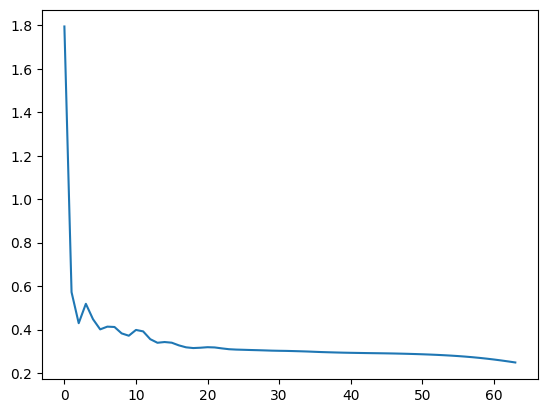

In [16]:
plt.plot(history_train);

In [17]:
def BFGS(w, dw, B_inv, lr_old):
    # search direction
    dir_v = -(B_inv @ dw)
    # line search
    lr = minimize(lambda x: loss_fast(unpack_params_fast(w + x[0] * dir_v)), jnp.array([0.1]), method="BFGS").x[0]
    if lr is None: # scipy may fail in finding the optimal search direction
        lr = lr_old
    lr_old = lr
    w_new = w + lr * dir_v # I use + sign because I inverted the sign of dir before
    dw_new = flat_list_into_numpy(loss_grad(unpack_params_fast(w_new)))
    # Sherman-Morrison update
    s = w_new - w
    y = dw_new - dw
    E = I - jnp.outer(y, s) / jnp.inner(y, s)
    B_inv = E.T @ B_inv @ E + jnp.outer(s, s) / jnp.inner(y, s)
    w = w_new
    dw = dw_new
    return w, dw, B_inv, lr_old # new values, after one BFGS iteration

BFGS_fast = jax.jit(BFGS)

In [18]:
# BFGS optimization
N = len(w)
max_epochs = 250
tol = 1e-6

dw = flat_list_into_numpy(loss_grad(unpack_params_fast(w)))
I = jnp.eye(N)
B_inv = I.copy()
history_train = list()

lr_old = 0.1

k = 250
tol_RAR = 1e-2
s = 10
max_grid_len = 200
epoch_step = 5

epoch = 0
while epoch < max_epochs and np.linalg.norm(dw) > tol:
    w, dw, B_inv, lr_old = BFGS_fast(w, dw, B_inv, lr_old)

    if epoch % epoch_step == 0 and len(grid) < max_grid_len:
        x = D[np.random.choice(len(D), k, replace=False)] # application of the RAR method
        y, e = loss_RAR_fast(x, unpack_params_fast(w)) # computing the error for each chosen method (Monte Carlo integration)
        if e >= tol_RAR:
            print(f"Adding to grid on epoch {epoch}, error = {e}")
            grid = np.vstack([grid, x[np.argpartition(y, -s)[-s:]]]) # adding critical points to the grid
        else:
            print(f"NOT adding to grid on epoch {epoch}, error = {e}")

    if epoch % epoch_step == 0 and len(grid) >= max_grid_len:
        print("Grid already full")

    if epoch % epoch_step == 0:
        l = loss_fast(unpack_params_fast(w))
        history_train.append(l)
        print(f"epoch {epoch}")
        print(f"loss: {l}")
        print(f"gradient norm: {np.linalg.norm(dw)}")
        print(f"length of the grid {len(grid)}\n")
    epoch += 1

print(f"\n\nLoss of the final iteration : {loss_fast(unpack_params_fast(w))}\n")

Adding to mesh on epoch 0, error = 0.08105327188968658
epoch 0
loss: 0.23590850830078125
gradient norm: 0.379874050617218
length of the mesh 110

Adding to mesh on epoch 5, error = 1.2000203132629395
epoch 5
loss: 0.14586330950260162
gradient norm: 0.320345014333725
length of the mesh 120

Adding to mesh on epoch 10, error = 0.40645748376846313
epoch 10
loss: 0.09483208507299423
gradient norm: 0.16435758769512177
length of the mesh 130

Adding to mesh on epoch 15, error = 0.45910853147506714
epoch 15
loss: 0.08548272401094437
gradient norm: 0.14652860164642334
length of the mesh 140

Adding to mesh on epoch 20, error = 0.354245126247406
epoch 20
loss: 0.07444211095571518
gradient norm: 0.11376509815454483
length of the mesh 150

Adding to mesh on epoch 25, error = 0.43539223074913025
epoch 25
loss: 0.06769119203090668
gradient norm: 0.08187925815582275
length of the mesh 160

Adding to mesh on epoch 30, error = 0.6179485321044922
epoch 30
loss: 0.061306096613407135
gradient norm: 0.353

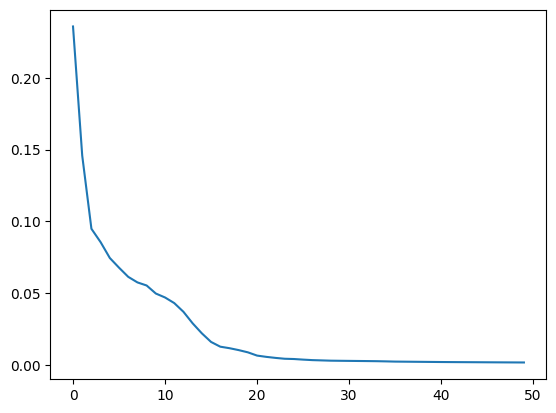

In [19]:
plt.plot(history_train);

In [20]:
params = unpack_params_fast(w)

In [24]:
'''import pickle # saving params and grid, locally
with open("params", "wb") as fp:
    pickle.dump(params, fp)
with open("grid", "wb") as fp:
    pickle.dump(grid, fp)'''

In [29]:
'''import pickle # loading params and grid, locally
with open("params", "rb") as fp:
    params = pickle.load(fp)
with open("grid", "rb") as fp:
    grid = pickle.load(fp)'''

# Plots for showing the results

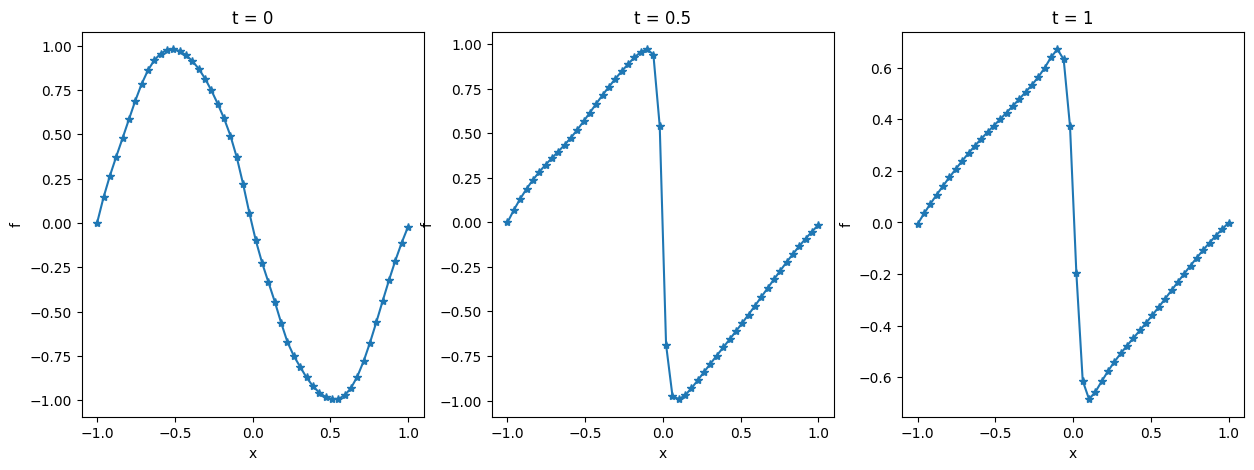

In [30]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), squeeze=False)
axes = axes.reshape(-1)

axes[0].plot([i for i in np.linspace(-1, 1, 50)],
         [ANN_single_point_fast(np.array([i, 0]), params) for i in np.linspace(-1, 1, 50)], marker="*")
axes[0].set_xlabel("x")
axes[0].set_ylabel("f")
axes[0].set_title("t = 0")
axes[1].plot([i for i in np.linspace(-1, 1, 50)],
         [ANN_single_point_fast(np.array([i, 0.5]), params) for i in np.linspace(-1, 1, 50)], marker="*")
axes[1].set_xlabel("x")
axes[1].set_ylabel("f")
axes[1].set_title("t = 0.5")
axes[2].plot([i for i in np.linspace(-1, 1, 50)],
         [ANN_single_point_fast(np.array([i, 1]), params) for i in np.linspace(-1, 1, 50)], marker="*")
axes[2].set_xlabel("x")
axes[2].set_ylabel("f")
axes[2].set_title("t = 1");

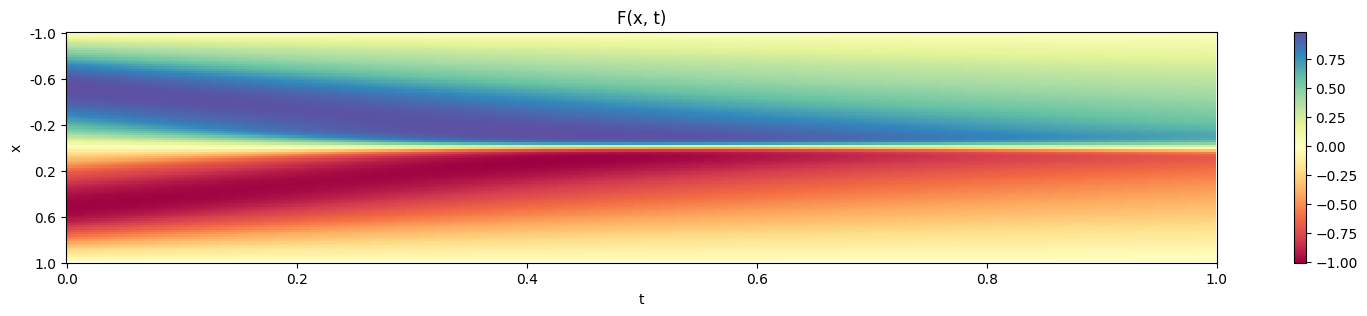

In [31]:
mat = np.array([
    [ANN_single_point_fast(np.array([x, t]), params) for t in np.linspace(0, 1, 500)] for x in np.linspace(-1, 1, 100)
])

plt.rcParams["figure.figsize"] = (20,3)
plt.imshow(mat, cmap='Spectral', interpolation='nearest')
plt.colorbar()

locs, _ = plt.xticks()
plt.xticks(locs[1:], np.round(np.linspace(0, 1, 6), 1))

locs, _ = plt.yticks()
plt.yticks(locs[1:], np.round(np.linspace(-1, 1, 6), 1))

plt.xlabel("t")
plt.ylabel("x")
plt.title("F(x, t)");

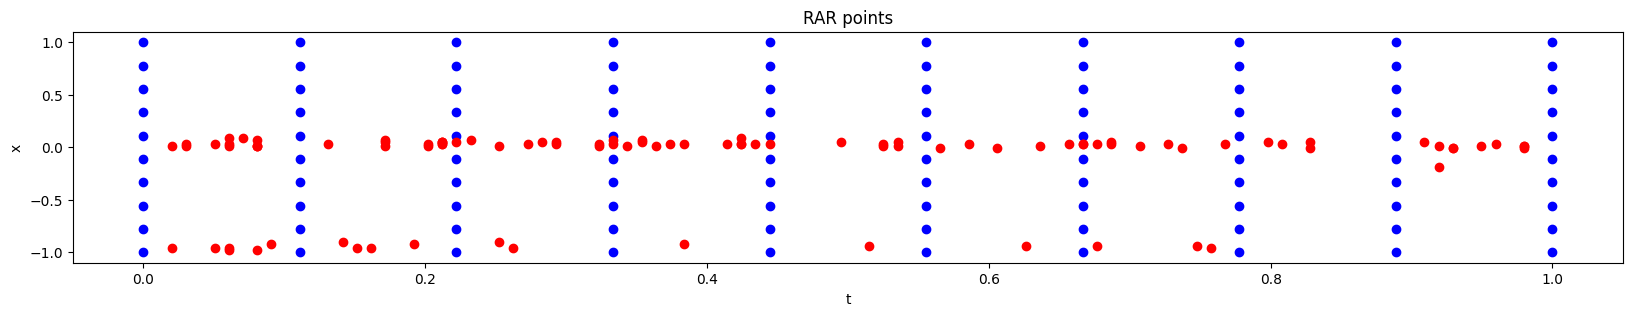

In [32]:
time_sample = np.linspace(0, 1, num_time_grid)
space_sample = np.linspace(-1, 1, num_space_grid)
original = np.array([[x, y] for x in space_sample for y in time_sample])
plt.scatter([i[1] for i in original], [i[0] for i in original], c="b")
rar = [i for i in grid if i not in original]
plt.scatter([i[1] for i in rar], [i[0] for i in rar], c="r")
plt.xlabel("t")
plt.ylabel("x")
plt.title("RAR points");